# Clusterização para organização das entregas
O centro Frei Humberto sente falta de uma maneira automatizada de organizar a entrega dos pedidos. Aqui será apresentada uma forma de agrupar os pedidos por localização, o que facilita a separação dos pedidos por entregador.<p>
Há pedidos que são agendados para retirada na sede da feira, porém, como são poucos, vamos relevar tal informação neste momento. Entretanto, deve haver preocupação em retirá-los da clusterização caso esta solução seja implementada em produção. Outra preocupação que aqui será ignorada é a remoção manual de pedidos cujas coordenadas geográficas não foram descobertas automaticamente.
<p>
Selecionaremos amostra de pedidos já realizados para testar as soluções implementadas. Como foi possível verificar no notebook <b>2 - Análise e Exploração dos Dados.ipynb</b>, o ciclo de vendas e entregas ocorre de forma mensal. Selecionaremos, portanto, os pedidos do mês com maior volume de pedido para  nossos testes.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

Primeiramente vamos verificar a quantidade de pedidos por mês. Trabalharemos com o mês com maior volume de vendas.

In [25]:
df =  pd.read_csv('arquivos/pedidos_wide_final.csv')
df['data_pedido'] = pd.to_datetime(df['data_pedido'])
df['data_pedido'] = df['data_pedido'].dt.to_period('M')
df['data_pedido'].value_counts()

2020-07    366
2020-08    322
2020-10    305
2020-09    293
2020-11    264
2020-12    262
2021-02    262
2021-01    212
2021-07    202
2021-05    195
2021-09    171
2021-06    164
2021-08    164
2021-10    138
2021-11     73
2022-02     61
2021-12     49
2022-01     24
Freq: M, Name: data_pedido, dtype: int64

Nossa massa será composta pelos pedidos de julho de 2020. Vamos separar esses pedidos e acrescentar a eles as coordenadas do CEP, que foram obtidas em **2.1 - Captura de coordenadas geográficas por CEP.ipynb**.

In [26]:
df = df[df['data_pedido'] == '2020-07'].filter(['id_pedido','cep_pedido'])

# Vamos ler as coordenadas de todos os CEPs presentes na massa de dados.
df_coords = pd.read_csv('arquivos/Coordenadas geográficas dos CEPs.csv')

# Definindo uma função que retorna as coordenadas geográficas de um CEP.
def ret_coord_geo(cep):
    if cep in list(df_coords['cep']):
        latitude = df_coords[df_coords['cep'] == cep]['lat'].values[0]
        longitude = df_coords[df_coords['cep'] == cep]['long'].values[0]
        return latitude,longitude
    else:
        return None,None
    
# Montando uma lista com as coordenadas geográficas de cada pedido.
lista_coords = [ret_coord_geo(cep) for cep in df['cep_pedido']]

# Acrescentando latitude e longitude ao DataFrame, removendo alguns poucos pedidos cujas coordenadas geográficas são
# desconhecidas.
df['lat'] = [pos[0] for pos in lista_coords]
df['long'] = [pos[1] for pos in lista_coords]
df.dropna(inplace=True)
df.head()

,id_pedido,cep_pedido,lat,long
0,54,60150060,-3.736327,-38.504833
1,56,60320105,-3.726792,-38.562826
2,59,60713480,-3.795657,-38.578317
3,60,60431075,-3.739664,-38.550117
4,64,60430660,-3.740088,-38.546496


Vamos visualizar os pedidos selecionados em um mapa.

In [27]:
mapa = folium.Map(location=[-3.77, -38.53],tiles='OpenStreetMap',zoom_start=12)
ped_coords = df[['id_pedido','lat','long']].values.tolist()

for id_p,lat,long in ped_coords:
    folium.CircleMarker([lat,long],popup=int(id_p),radius=2,color='blue').add_to(mapa)

folium.Marker([-3.7571739265915802,-38.51565613865088],popup='Sede do Centro Frei Humberto').add_to(mapa)
mapa

# DBSCAN + K-Means
Utilizaremos primeiramente DBSCAN para separar outliers que ficam muito distantes, cuja entrega deve ser realizada de maneira diferenciada, aplicando, então, K-Means para separar o restante dos pedidos em grupos.<p>
O X consistirá somente nos pontos de latitude e longitude, dado que eles que indicam o ponto de entrega. Os dados serão normalizados. Para maiores detalhes do funcionamento, da análise dos dados e da seleção de hiper parâmetros do DBSCAN, verificar o notebook **3 - Detecção de outliers com agrupamento DBSCAN.ipynb**, onde ele já foi previamente utilizado e explicado.

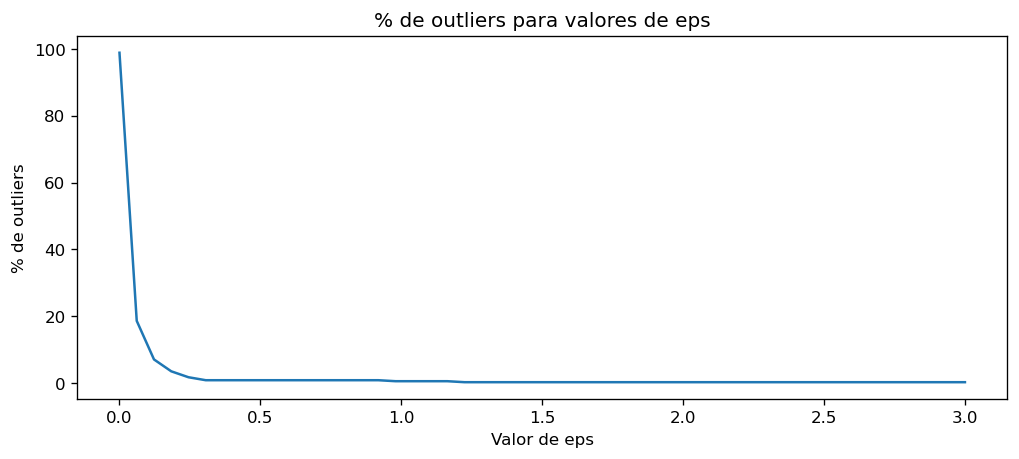

In [28]:
X = df[['lat','long']]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

percent_outliers = list()
ms = scaled_X.shape[1] * 2
lista_eps = np.linspace(0.001,3,50) # 50 valores que testaremos para eps

for eps in lista_eps:
    modelo_dbscan = DBSCAN(min_samples=ms,eps=eps)
    modelo_dbscan.fit(scaled_X)
    
    nr_outliers = np.sum(modelo_dbscan.labels_ == -1) # DBSCAN atribui label -1 aos outliers
    perc_outliers = 100 * nr_outliers / len(modelo_dbscan.labels_)
    percent_outliers.append(perc_outliers)
    
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps');

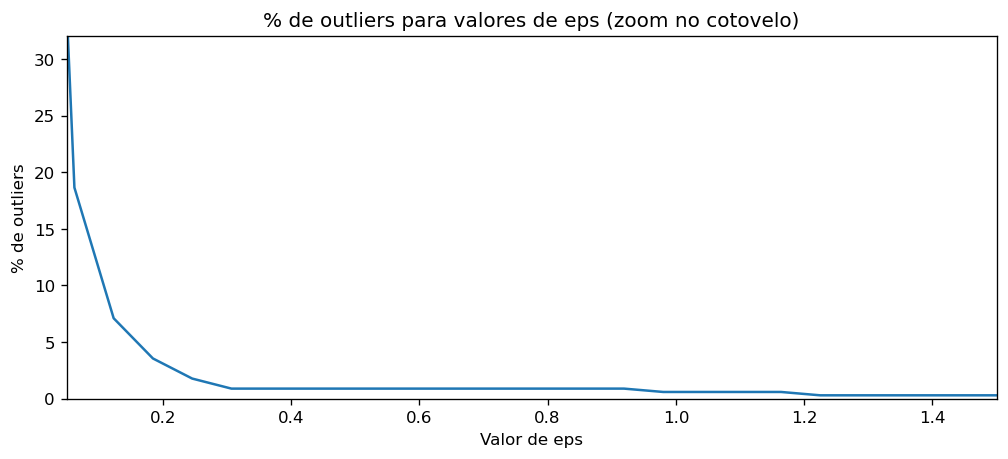

In [29]:
plt.figure(dpi=120,figsize=(10,4))
ax = sns.lineplot(x=lista_eps,y=percent_outliers)
ax.set(xlabel='Valor de eps',ylabel='% de outliers',title='% de outliers para valores de eps (zoom no cotovelo)')
plt.xlim(0.05,1.5)
plt.ylim(0,32);

Trabalharemos com 0.3 como valor de eps, que parece estar estimando uma boa quantidade de pontos muito afastados. Vejamos quantos endereços foram selecionados como outliers.

In [30]:
modelo_dbscan = DBSCAN(min_samples=ms,eps=0.3)
labels = modelo_dbscan.fit_predict(scaled_X)
df['label'] = labels
df['label'].value_counts()

 0    334
-1      4
Name: label, dtype: int64

Vamos visualizar estes outliers no mapa. Estão marcados com a cor vermelha.

In [31]:
mapa = folium.Map(location=[-8, -38.53],tiles='OpenStreetMap',zoom_start=6)
ped_coords = df[['id_pedido','lat','long','label']].values.tolist()

for id_p,lat,long,label in ped_coords:
    if label == -1:
        cor = 'red'
    else:
        cor = 'blue'

    folium.CircleMarker([lat,long],popup=int(id_p),color=cor,radius=2).add_to(mapa)

mapa

Vamos separar os outliers do resto dos pedidos para fazer a clusterização dos que não são outliers com K-Means.

In [32]:
df_outliers = df[df['label'] == -1].copy()
df = df[df['label'] != -1]

Vamos assumir que há 5 entregadores, o que resulta na necessidade de criação de 5 clusters. Inicialmente vamos simplesmente classificar os dados uma única vez com K-Means e verificar os resultados, lembrando que a escolha inicial dos centros dos clusters é aleatória, o que implica na geração de diferentes clusters a cada execução.

In [33]:
X = df[['lat','long']]
scaled_X = scaler.fit_transform(X)

modelo_kmeans = KMeans(n_clusters=5)
labels = modelo_kmeans.fit_predict(scaled_X)
df['label'] = labels

df['label'].value_counts()

2    131
0     98
4     38
3     36
1     31
Name: label, dtype: int64

Podemos ver que a quantidade de entregas por entregador não ficou muito equilibrada, mas é importante lembrar que não é somente esta a única variável que determina o tempo de trabalho de um entregador. A distância a ser percorrida entre os pontos também deve ser levada em consideração. Visualizemos a divisão no mapa para melhor compreender esta questão.

In [34]:
mapa = folium.Map(location=[-3.77, -38.53],tiles='OpenStreetMap',zoom_start=12)
ped_coords = df[['id_pedido','lat','long','label']].values.tolist()

for id_p,lat,long,label in ped_coords:
    if label ==  0:
        cor = 'green'
    elif label == 1:
        cor = 'red'
    elif label == 2:
        cor = 'purple'
    elif label == 3:
        cor = 'black'
    else:
        cor = 'darkblue'

    folium.CircleMarker([lat,long],popup=int(id_p),color=cor,radius=2).add_to(mapa)

folium.Marker([-3.7571739265915802,-38.51565613865088],popup='Sede do Centro Frei Humberto').add_to(mapa)
mapa

No geral, esta é uma boa divisão pois o tempo de trabalho de um entregador depende tanto das entregas a serem feitas quanto do tempo de deslocamento necessário para deslocar-se de um ponto a outro. Em poutras palavras, o pagamento pelos serviços de entrega leva em consideração tanto a quantidade de quilômetros rodados quanto a quantidade de entregas efetuadas.

In [59]:
import heapq

In [225]:
cluster_entregas = 1

df_ce = df[df['label'] == cluster_entregas].copy()
df_ce.reset_index(inplace=True)

# Matriz de distâncias euclidianas entre os pontos
points = df_ce[['lat','long']].values.tolist()
points.insert(0,[-3.7571739265915802,-38.51565613865088]) # Inserção das coordenadas do centro no início da lista

pts = np.array(points)
dist = np.abs(pts[np.newaxis,:,:] - pts[:,np.newaxis,:]).min(axis=2)

# Xunxo para eliminar distâncias iguais
soma = 0.0000000000000001
for cont_x,x in enumerate(dist):
    for cont_y,y in enumerate(x):
        dist[cont_x][cont_y] += soma
        soma += 0.0000000000000001

    soma = 0.0000000000000001

# Montagem do itinerário
calcular = True
pto_analisado = 0
itinerario_pos = list()
somar_n_pto_menor = 0

while calcular:
    if len(itinerario_pos) == len(dist):
        break

    while True:
        if pto_analisado == 0:
            n_pto_menor = 2
            itinerario_pos.append(0)
        else:
            n_pto_menor = 3 + somar_n_pto_menor

        pto_mais_proximo = int(np.where(dist[pto_analisado] == heapq.nsmallest(n_pto_menor, dist[pto_analisado])[-1])[0])

        if not pto_mais_proximo in itinerario_pos:
            itinerario_pos.append(pto_mais_proximo)
            pto_analisado = pto_mais_proximo
            somar_n_pto_menor = 0
            break
        else:
            somar_n_pto_menor += 1

In [226]:
print(itinerario_pos)

[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8, 25, 15, 7, 23, 9, 20, 28, 16, 19, 31, 14, 21, 3, 1, 6, 12, 30]


In [227]:
itinerario_pos.pop(0)
itinerario_pos = [pos -1 for pos in itinerario_pos]
print(itinerario_pos)

[9, 12, 21, 28, 10, 25, 16, 17, 23, 3, 4, 26, 1, 7, 24, 14, 6, 22, 8, 19, 27, 15, 18, 30, 13, 20, 2, 0, 5, 11, 29]


In [239]:
itinerario = [df_ce['id_pedido'].iloc[id_p] for id_p in itinerario_pos]
print(itinerario) # Por número de pedido

[455, 502, 799, 894, 468, 860, 671, 677, 830, 122, 146, 868, 83, 285, 852, 627, 174, 829, 289, 752, 892, 668, 703, 941, 572, 787, 93, 65, 168, 485, 925]


In [241]:
df_ce

,index,id_pedido,cep_pedido,lat,long,label
0,5,65,60812475,-3.774197,-38.457283,1
1,13,83,60822482,-3.798595,-38.494533,1
2,17,93,60813730,-3.778506,-38.490863,1
3,26,122,60861770,-3.812270,-38.522159,1
4,33,146,60861790,-3.817321,-38.521025,1
5,41,168,60811030,-3.772304,-38.485393,1
6,43,174,60821230,-3.787623,-38.502227,1
7,77,285,60840280,-3.832838,-38.494093,1
8,78,289,60820490,-3.781931,-38.506652,1
9,141,455,60864100,-3.799908,-38.510501,1


In [61]:
heapq.nsmallest(2, dist[0]) # dois menores valores

[0.0, 0.0051550386508836255]

In [62]:
dist[0]

array([0.        , 0.01702272, 0.02112284, 0.02133177, 0.00650276,
       0.00536906, 0.01512967, 0.01342884, 0.02156264, 0.00900384,
       0.00515504, 0.01630904, 0.01690177, 0.01605416, 0.01771626,
       0.03206167, 0.03879254, 0.03316144, 0.03276234, 0.02382196,
       0.01879924, 0.02255834, 0.01674384, 0.01140364, 0.00898926,
       0.04085104, 0.03295714, 0.02084754, 0.01659794, 0.01659794,
       0.01413187, 0.01372576])

In [117]:
np.where(dist[0] == heapq.nsmallest(2, dist[0])[1]) # posição do segundo menor valor

(array([10]),)

In [194]:
calcular = True
pto_analisado = 0
itinerario = list()
somar_n_pto_menor = 0

while calcular:
    if len(itinerario) == len(dist):
        break
    print(itinerario,len(itinerario))

    while True:
        if pto_analisado == 0:
            n_pto_menor = 2
            itinerario.append(0)
        else:
            n_pto_menor = 3 + somar_n_pto_menor
        print(np.where(dist[pto_analisado] == heapq.nsmallest(n_pto_menor, dist[pto_analisado])[-1])[0])
        pto_mais_proximo = int(np.where(dist[pto_analisado] == heapq.nsmallest(n_pto_menor, dist[pto_analisado])[-1])[0])

        if not pto_mais_proximo in itinerario:
            itinerario.append(pto_mais_proximo)
            pto_analisado = pto_mais_proximo
            somar_n_pto_menor = 0
            break
        else:
            somar_n_pto_menor += 1

itinerario

[] 0
[10]
[0, 10] 2
[13]
[0, 10, 13] 3
[22]
[0, 10, 13, 22] 4
[29]
[0, 10, 13, 22, 29] 5
[22]
[11]
[0, 10, 13, 22, 29, 11] 6
[29]
[22]
[26]
[0, 10, 13, 22, 29, 11, 26] 7
[17]
[0, 10, 13, 22, 29, 11, 26, 17] 8
[18]
[0, 10, 13, 22, 29, 11, 26, 17, 18] 9
[17]
[24]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24] 10
[4]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4] 11
[5]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5] 12
[4]
[24]
[18]
[27]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27] 13
[2]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2] 14
[8]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8] 15
[27]
[25]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8, 25] 16
[29]
[8]
[15]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8, 25, 15] 17
[7]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8, 25, 15, 7] 18
[23]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8, 25, 15, 7, 23] 19
[7]
[9]
[0, 10, 13, 22, 29, 11, 26, 17, 18, 24, 4, 5, 27, 2, 8, 25, 15, 7, 23, 9] 20
[20]


[0,
 10,
 13,
 22,
 29,
 11,
 26,
 17,
 18,
 24,
 4,
 5,
 27,
 2,
 8,
 25,
 15,
 7,
 23,
 9,
 20,
 28,
 16,
 19,
 31,
 14,
 21,
 3,
 1,
 6,
 12,
 30]

In [189]:
np.where(dist[19] == heapq.nsmallest(9, dist[19])[-1])

(array([28, 29]),)

In [177]:
heapq.nsmallest(9, dist[19]) 

[2.000000000000001e-17,
 0.0021740000000001355,
 0.005277299999999947,
 0.007233700000000018,
 0.0077677999999963415,
 0.0080201,
 0.008284000000000185,
 0.008453999999999991,
 0.008453999999999991]

In [174]:
dist[19]

array([2.38219613e-02, 5.14080500e-02, 2.70101000e-02, 4.70990000e-02,
       1.33342000e-02, 8.28400000e-03, 5.33011000e-02, 3.72508000e-02,
       7.23370000e-03, 3.28258000e-02, 2.56966000e-02, 3.11441000e-02,
       4.92982000e-02, 7.76780000e-03, 2.17400000e-03, 3.63691000e-02,
       5.27730000e-03, 1.93424000e-02, 1.17038000e-02, 2.00000000e-17,
       4.07919000e-02, 3.30194000e-02, 3.01587000e-02, 3.52256000e-02,
       1.11797000e-02, 8.02010000e-03, 3.21827000e-02, 1.35144000e-02,
       8.45400000e-03, 8.45400000e-03, 5.42989000e-02, 8.72830000e-03])

In [140]:
dist[0]

array([0.        , 0.01702272, 0.02112284, 0.02133177, 0.00650276,
       0.00536906, 0.01512967, 0.01342884, 0.02156264, 0.00900384,
       0.00515504, 0.01630904, 0.01690177, 0.01605416, 0.01771626,
       0.03206167, 0.03879254, 0.03316144, 0.03276234, 0.02382196,
       0.01879924, 0.02255834, 0.01674384, 0.01140364, 0.00898926,
       0.04085104, 0.03295714, 0.02084754, 0.01659794, 0.01659794,
       0.01413187, 0.01372576])

In [142]:
dist[0][0] += 1

In [191]:
dist

array([[0.        , 0.01702272, 0.02112284, ..., 0.01659794, 0.01413187,
        0.01372576],
       [0.01702272, 0.        , 0.02439795, ..., 0.04177488, 0.00289085,
        0.04267975],
       [0.02112284, 0.02439795, 0.        , ..., 0.0045249 , 0.0094352 ,
        0.0182818 ],
       ...,
       [0.01659794, 0.04177488, 0.0045249 , ..., 0.        , 0.0139601 ,
        0.0171823 ],
       [0.01413187, 0.00289085, 0.0094352 , ..., 0.0139601 , 0.        ,
        0.0442838 ],
       [0.01372576, 0.04267975, 0.0182818 , ..., 0.0171823 , 0.0442838 ,
        0.        ]])

In [192]:
soma = 0.0000000000000001
for cont_x,x in enumerate(dist):
    for cont_y,y in enumerate(x):
        dist[cont_x][cont_y] += soma
        soma += 0.0000000000000001

    soma = 0.0000000000000001

In [217]:
df['label'] == cluster_entregas

0      False
1      False
2      False
3      False
4      False
       ...  
360    False
361    False
362    False
364    False
365    False
Name: label, Length: 334, dtype: bool

In [240]:
df_ce

,index,id_pedido,cep_pedido,lat,long,label
0,5,65,60812475,-3.774197,-38.457283,1
1,13,83,60822482,-3.798595,-38.494533,1
2,17,93,60813730,-3.778506,-38.490863,1
3,26,122,60861770,-3.812270,-38.522159,1
4,33,146,60861790,-3.817321,-38.521025,1
5,41,168,60811030,-3.772304,-38.485393,1
6,43,174,60821230,-3.787623,-38.502227,1
7,77,285,60840280,-3.832838,-38.494093,1
8,78,289,60820490,-3.781931,-38.506652,1
9,141,455,60864100,-3.799908,-38.510501,1
